In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.utils import to_categorical
import numpy as np
from transformers import CLIPProcessor, CLIPModel
import torch
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [3]:
!kaggle datasets download -d msambare/fer2013

Dataset URL: https://www.kaggle.com/datasets/msambare/fer2013
License(s): DbCL-1.0
 98% 59.0M/60.3M [00:04<00:00, 16.8MB/s]
100% 60.3M/60.3M [00:04<00:00, 14.2MB/s]


In [4]:
!unzip /content/fer2013.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/sad/Training_65242339.jpg  
  inflating: train/sad/Training_65267116.jpg  
  inflating: train/sad/Training_65275626.jpg  
  inflating: train/sad/Training_6529266.jpg  
  inflating: train/sad/Training_65329617.jpg  
  inflating: train/sad/Training_65338712.jpg  
  inflating: train/sad/Training_65338797.jpg  
  inflating: train/sad/Training_65387162.jpg  
  inflating: train/sad/Training_65404494.jpg  
  inflating: train/sad/Training_65426218.jpg  
  inflating: train/sad/Training_65430136.jpg  
  inflating: train/sad/Training_65437377.jpg  
  inflating: train/sad/Training_6545735.jpg  
  inflating: train/sad/Training_65463385.jpg  
  inflating: train/sad/Training_65473985.jpg  
  inflating: train/sad/Training_65502829.jpg  
  inflating: train/sad/Training_65505359.jpg  
  inflating: train/sad/Training_65508578.jpg  
  inflating: train/sad/Training_65516023.jpg  
  inflating: train/sad/Training_65524027.jpg  
  inflating

In [5]:
# Define the dataset paths
train_dataset_path = '/content/train'
test_dataset_path = '/content/test'

# Load the dataset
batch_size = 16
img_height = 48
img_width = 48

train_dataset = image_dataset_from_directory(
    train_dataset_path,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode='rgb'
)

validation_dataset = image_dataset_from_directory(
    test_dataset_path,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode='rgb'
)

Found 28709 files belonging to 7 classes.
Found 7178 files belonging to 7 classes.


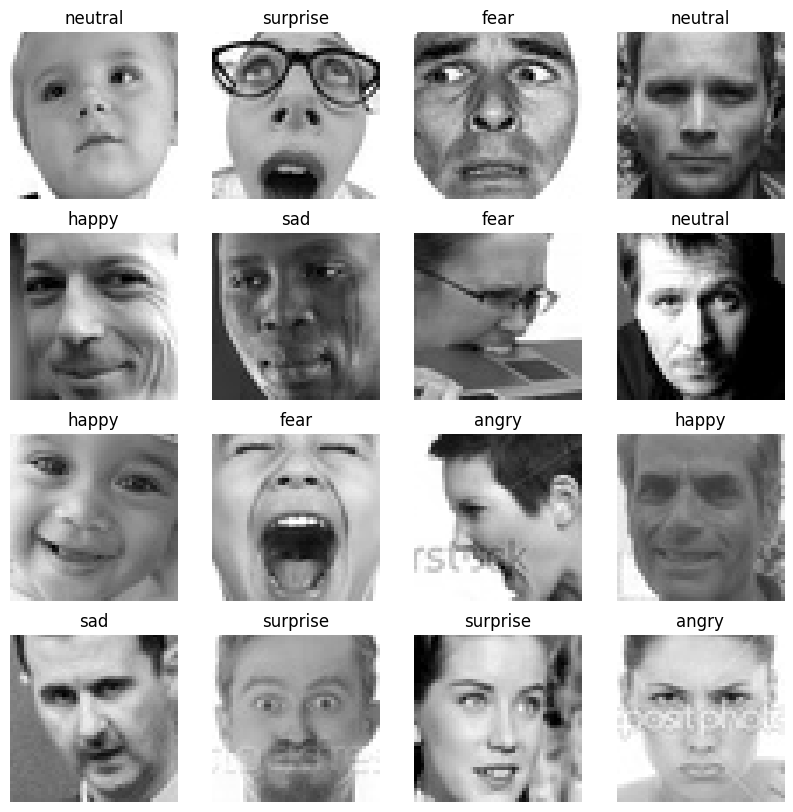

In [7]:
from operator import imod
# Function to plot images with labels
import matplotlib.pyplot as plt
def plot_images(dataset, class_names, num_images=16):
    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1):
        for i in range(num_images):
            ax = plt.subplot(4, 4, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[labels[i]])
            plt.axis("off")

# Get the class names
class_names = train_dataset.class_names

# Plot some training images
plot_images(train_dataset, class_names)

# Show the plot
plt.show()

In [8]:
# Load the CLIP model and processor
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

In [9]:
# Function to extract features using the CLIP model
def extract_features(dataset):
    features = []
    labels = []
    for images, label in dataset:
        inputs = processor(images=images.numpy(), return_tensors="pt", padding=True)
        outputs = model.get_image_features(**inputs)
        features.append(outputs.detach().numpy())
        labels.append(label.numpy())
    return np.concatenate(features), np.concatenate(labels)

In [10]:
# Extract features for training and validation datasets
X_train_features, y_train = extract_features(train_dataset)
X_val_features, y_val = extract_features(validation_dataset)

It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.


In [11]:
# Define the classifier model
classifier = Sequential([
    Dense(512, activation='relu', input_shape=(X_train_features.shape[1],)),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(len(train_dataset.class_names), activation='softmax')
])

In [12]:
# Compile the model
classifier.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [13]:
# Train the classifier
history = classifier.fit(X_train_features, y_train, epochs=20, batch_size=batch_size, validation_data=(X_val_features, y_val))

Epoch 1/20
1795/1795 [==============================] - 12s 5ms/step - loss: 1.1711 - accuracy: 0.5677 - val_loss: 0.9928 - val_accuracy: 0.6220
Epoch 2/20
1795/1795 [==============================] - 7s 4ms/step - loss: 1.0513 - accuracy: 0.6130 - val_loss: 0.9512 - val_accuracy: 0.6365
Epoch 3/20
1795/1795 [==============================] - 8s 4ms/step - loss: 1.0193 - accuracy: 0.6245 - val_loss: 0.9589 - val_accuracy: 0.6385
Epoch 4/20
1795/1795 [==============================] - 7s 4ms/step - loss: 0.9994 - accuracy: 0.6297 - val_loss: 0.9468 - val_accuracy: 0.6428
Epoch 5/20
1795/1795 [==============================] - 8s 4ms/step - loss: 0.9897 - accuracy: 0.6338 - val_loss: 0.9336 - val_accuracy: 0.6474
Epoch 6/20
1795/1795 [==============================] - 7s 4ms/step - loss: 0.9715 - accuracy: 0.6397 - val_loss: 0.9246 - val_accuracy: 0.6439
Epoch 7/20
1795/1795 [==============================] - 8s 4ms/step - loss: 0.9577 - accuracy: 0.6479 - val_loss: 0.9141 - val_accuracy

In [14]:
# Evaluate the model
loss, accuracy = classifier.evaluate(X_val_features, y_val)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")


225/225 [==============================] - 1s 3ms/step - loss: 0.9156 - accuracy: 0.6597
Validation Accuracy: 65.97%


In [15]:
# Save the trained model
classifier.save('facial_expression_recognition_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


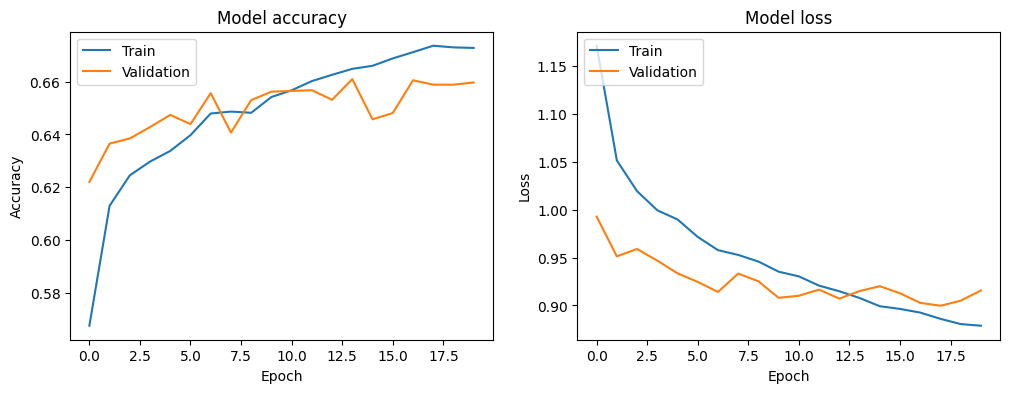

In [16]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()
